In [1]:
1*2

2

In [41]:
import importlib
def rl():
    importlib.reload(Di)

In [3]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


In [4]:
import dask.dataframe as dd
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [5]:
import torch
import gpytorch

In [6]:
import pyarrow as pa
import pyarrow.parquet as pq

In [7]:
from scipy.stats import pearsonr
from scipy.special import binom as binom
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [8]:
import Di

In [9]:
geno_file_list = []
for path, currentDirectory, files in os.walk("96ghpptzvf-4/SData2/"):
    for file in files:
        if file.endswith("geno.txt"):
            geno_file_list.append(file)

geno_file_list = list(set(geno_file_list))

env_list = [file.split('_')[0] for file in geno_file_list]

env_list = sorted(env_list)

In [10]:
env_list

['CoCl2',
 'CuSO4',
 'Glucose',
 'Glucose2',
 'H2O2',
 'NaCl',
 'Rapamycin',
 'Zeocin']

In [11]:
env = env_list[5]
print(env)

NaCl


In [12]:
df = pd.read_csv("96ghpptzvf-4/SData2/"+ env + "_geno.txt", sep='\t', nrows=5, engine='python')

In [13]:
ids = list(df.columns[3:])

In [14]:
env + '_matsui_geno_t.pt'

'NaCl_matsui_geno_t.pt'

In [15]:
geno_t = torch.load(env + '_matsui_geno_t.pt')

In [16]:
geno_t

tensor([[1., 2., 1.,  ..., 0., 0., 0.],
        [1., 2., 1.,  ..., 0., 0., 0.],
        [1., 2., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 2., 2.,  ..., 1., 1., 1.],
        [1., 2., 2.,  ..., 1., 1., 1.],
        [1., 2., 2.,  ..., 1., 1., 1.]], device='cuda:0', dtype=torch.float64)

In [17]:
geno_t = torch.transpose(geno_t, 0, 1)
N, L = geno_t.shape

In [18]:
pheno = pd.read_csv("96ghpptzvf-4/SData6/" + env + "_pheno.txt", sep='\t', engine="python")

In [19]:
pheno = pheno.set_index('geno')

In [20]:
pheno = pheno.loc[ids]

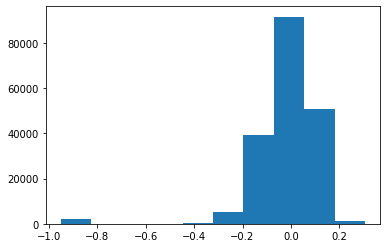

In [21]:
plt.hist(pheno.pheno)
plt.show()

### test Diploid kernel

In [22]:
geno_ti = torch.tensor(geno_t, dtype=torch.int16)

/scratch/local/29112460/ipykernel_62872/3963038291.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  geno_ti = torch.tensor(geno_t, dtype=torch.int16)


In [23]:
# inds_sub = np.arange(len(geno_t))
inds_sub = np.where(np.array(pheno.pheno < -0.6) == False)[0]

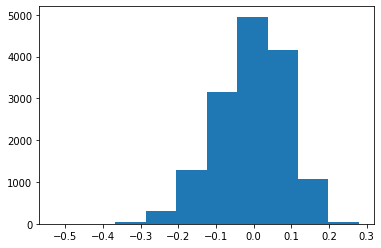

In [24]:
sub = np.random.choice(inds_sub, 15000)
# sub = np.random.choice(range(N), 10000)
plt.hist(pheno.pheno[sub])
plt.show()

In [25]:
import Di
Di.set_params(geno_t[sub])

In [26]:
p = .8

In [27]:
from torch.utils.data import random_split
train, test = random_split(range(Di.N), lengths=[round(Di.N*p), Di.N-round(Di.N*p)])

In [28]:
y = np.array(pheno.pheno[sub])
y = torch.tensor(y)

In [29]:
idc = torch.arange(Di.N)

In [30]:
train_x = idc[train]
train_y = torch.tensor(y[train])
test_x = idc[test]
test_y = torch.tensor(y[test])

/scratch/local/29112460/ipykernel_62872/2969457204.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(y[train])
/scratch/local/29112460/ipykernel_62872/2969457204.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y = torch.tensor(y[test])


In [31]:
train_x = train_x.cuda()
train_y = train_y.cuda().float()

In [32]:
print(train_x.shape, test_x.shape)

torch.Size([12000]) torch.Size([3000])


In [33]:
# Di.make_elem_Ks(2)

## Linear kernel

In [34]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
model = Di.LinGPModel(train_x, train_y, likelihood)
model = model.cuda().double()

In [35]:
model.train()
output = model(train_x)

In [36]:
model.train()
likelihood.train()
losses = Di.train_model(model, likelihood, train_x, train_y, training_iter=20, lr=.01)

0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


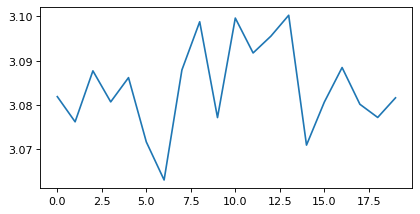

In [37]:
figure(figsize=(6, 3), dpi=80)
plt.plot(losses)
plt.show()

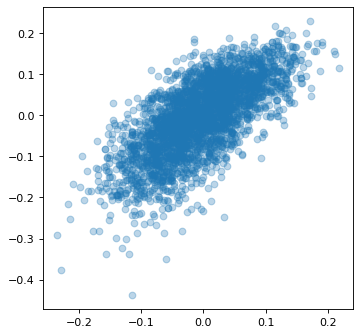

r2 = 0.496702
R2 = 0.494818
mse = 0.004171


In [38]:
test_x = test_x.cuda()

model.eval()
f_preds = model(test_x)

f_mean = f_preds.mean.cpu()

# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), y[test], 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), y[test])[0]**2)
print('R2 = %f'%r2(y[test], f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), y[test]))

## Diploid kernel

In [46]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# initialize the new model
# model = Di.DiGPModel_mix(train_x, train_y, likelihood)
# model = Di.LinGPModel(train_x, train_y, likelihood)
model = Di.DiGPModel(train_x, train_y, likelihood)
# model = Di.RBFGPModel(train_x, train_y, likelihood)

In [47]:
model = model.cuda().double()
likelihood = likelihood.cuda()

In [48]:
model.covar_module.raw_lda = torch.nn.Parameter(torch.tensor(-8.))
model.covar_module.raw_eta = torch.nn.Parameter(torch.tensor(-12.))

# model.covar_module.raw_ld1 = torch.nn.Parameter(torch.tensor(-8.))
# model.covar_module.raw_et1 = torch.nn.Parameter(torch.tensor(-12.))

In [49]:
model.train()
output = model(train_x)

In [50]:
rl()

In [53]:
kernel = Di.DiKernel()

In [51]:
with gpytorch.beta_features.checkpoint_kernel(10000), \
     gpytorch.settings.max_preconditioner_size(100):


    model.train()
    likelihood.train()
    losses = Di.train_model(model, likelihood, train_x, train_y, training_iter=400, lr=.02)

0


RuntimeError: scatter_cuda_(): Expected self.dtype to be equal to src.dtype

In [44]:
print(model.covar_module.raw_lda,model.covar_module.raw_eta)

Parameter containing:
tensor(-11.2916, requires_grad=True) Parameter containing:
tensor(-15.3419, requires_grad=True)


In [45]:
# model.covar_module.raw_lda = torch.nn.Parameter(torch.tensor(-10.6562))
# model.covar_module.raw_eta = torch.nn.Parameter(torch.tensor(-16.2755))


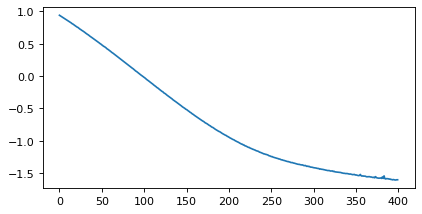

In [46]:
figure(figsize=(6, 3), dpi=80)
plt.plot(losses)
plt.show()

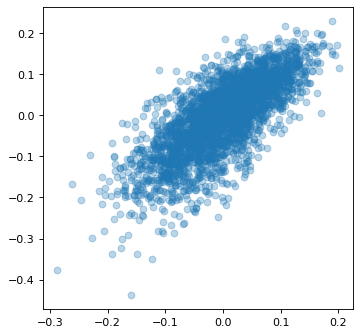

r2 = 0.559685
R2 = 0.556594
mse = 0.003661


In [47]:
test_x = test_x.cuda()

model.eval()
f_preds = model(test_x)

f_mean = f_preds.mean.cpu()

# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), y[test], 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), y[test])[0]**2)
print('R2 = %f'%r2(y[test], f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), y[test]))

In [48]:
# test_y = torch.tensor(y[test]).cuda()

# optimizer = torch.optim.AdamW(model.parameters(), .002)
# losses = []

# for i in range(50):
    
#     optimizer.zero_grad()
#     # Output from model
#     model.eval()
#     f_preds = model(test_x).mean

#     # Calc loss and backprop gradients
#     loss = torch.norm(f_preds - test_y)
#     print(loss)

#     loss.backward()
#     losses.append(loss.item())
#     optimizer.step()    

In [49]:
# test_x = test_x.cuda()

# model.eval()
# f_preds = model(test_x)

# f_mean = f_preds.mean.cpu()

# # epistatic
# figure(figsize=(5, 5), dpi=80)
# plt.plot(f_mean.detach().numpy(), y[test], 'o', alpha=.3)
# plt.show()
# print('r2 = %f'%pearsonr(f_mean.detach().numpy(), y[test])[0]**2)
# print('R2 = %f'%r2(y[test], f_mean.detach().numpy()))
# print('mse = %f'%mse(f_mean.detach().numpy(), y[test]))

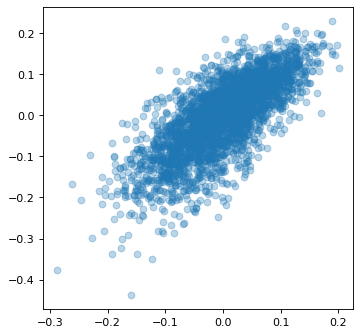

r2 = 0.559685
R2 = 0.556594
mse = 0.003661


In [50]:
test_x = test_x.cuda()

model.eval()
f_preds = model(test_x)

f_mean = f_preds.mean.cpu()

# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), y[test], 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), y[test])[0]**2)
print('R2 = %f'%r2(y[test], f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), y[test]))

## RBF kernel

In [51]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
model = Di.RBFGPModel(train_x, train_y, likelihood)
model = model.cuda().double()

In [52]:
model.train()
likelihood.train()
losses = Di.train_model(model, likelihood, train_x, train_y, training_iter=100, lr=.05)

0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


20
40
60
80


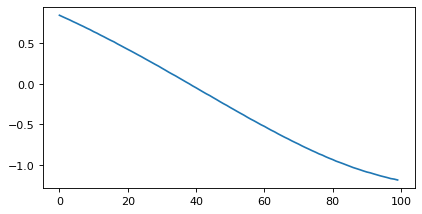

In [53]:
figure(figsize=(6, 3), dpi=80)
plt.plot(losses)
plt.show()

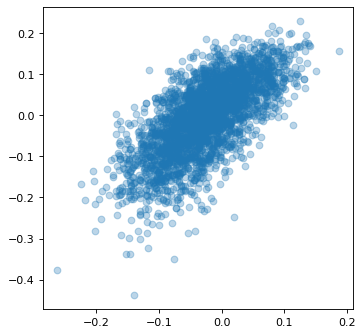

r2 = 0.483903
R2 = 0.429862
mse = 0.004707


In [54]:
test_x = test_x.cuda()

model.eval()
f_preds = model(test_x)

f_mean = f_preds.mean.cpu()

# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), y[test], 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), y[test])[0]**2)
print('R2 = %f'%r2(y[test], f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), y[test]))

In [55]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [59]:
test_y = torch.tensor(y[test]).cuda()

optimizer = torch.optim.AdamW(model.parameters(), .001)
losses = []

for i in range(50):
    
    optimizer.zero_grad()
    # Output from model
    model.eval()
    f_preds = model(test_x).mean

    # Calc loss and backprop gradients
    loss = torch.norm(f_preds - test_y)
    print(loss)

    loss.backward()
    losses.append(loss.item())
    optimizer.step()    

/scratch/local/26741152/ipykernel_137872/1551297166.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y = torch.tensor(y[test]).cuda()


tensor(3.5948, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)
tensor(3.5814, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)
tensor(3.5766, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)
tensor(3.5782, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)
tensor(3.5813, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)
tensor(3.5823, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)
tensor(3.5809, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)
tensor(3.5787, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)
tensor(3.5770, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)
tensor(3.5766, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)
tensor(3.5773, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)
tensor(3.5784, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)
tensor(3.5791, device='cuda:0', dtype=torch.float64, grad_fn=<Co

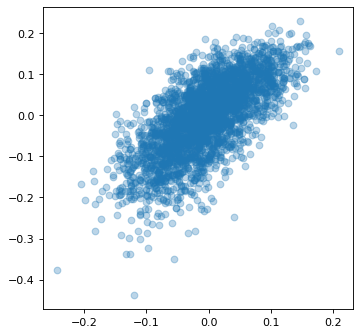

r2 = 0.483974
R2 = 0.483569
mse = 0.004264


In [60]:
test_x = test_x.cuda()

model.eval()
f_preds = model(test_x)

f_mean = f_preds.mean.cpu()

# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), y[test], 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), y[test])[0]**2)
print('R2 = %f'%r2(y[test], f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), y[test]))